In [1]:
import csv
import numpy as np
import Loader
import tensorflow as tf
import Transformer
from sklearn import preprocessing
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.losses import MeanSquaredError

In [3]:
compoundsTrain, smilesTrain, labelsTrain, compoundDataTrain, activitiesTrain = Loader.getTrain(defaultValue=0)
compoundsTest, smilesTest, labelsTest, compoundDataTest, activitiesTest = Loader.getTest(defaultValue=0)
compoundsValidate, smilesValidate, labelsValidate, compoundDataValidate, activitiesValidate = Loader.getValidate(defaultValue=0)

#print(labelsTrain)
#print(compoundsTrain)
#print(smilesTrain)
#print(activitiesTrain)

#for i in range(len(labelsTrain)):
#    print(labelsTrain[i] + ": ", compoundDataTrain[0,i])

def toClassification(y): # The resulting array will contain values of -1 if it is below 4.5 and 1 if it is above
    y = np.array(y)
    classification = (y.astype(float)>4).astype(int)
    return classification * 2 - 1

def normalizeData(train,test,validate):
    for i in range(np.shape(train)[1]):
        std = np.std(train[:,i])
        mean = np.mean(train[:,i])
        if(std == 0):
            std = 1
        train[:,i] = (train[:,i] - mean) / std
        test[:,i] = (test[:,i] - mean) / std
        validate[:,i] = (validate[:,i] - mean) / std
    return train, test, validate

def makeAverage(arr): # Averages the ten values for each score and creates a new array
    arr = np.array(arr)
    newArr = np.empty((np.shape(arr)[0], np.shape(arr)[1] - 18))
    newArr[:,0] = np.mean(arr[:,:10], axis = 1)
    newArr[:,1] = np.mean(arr[:,10:20], axis = 1)
    newArr[:,2:] = arr[:,20:]
    return newArr

def averageScores(train, test, validate): #wrapper function to handle all conversions at once
    newTrain = makeAverage(train)
    newTest = makeAverage(test)
    newValid = makeAverage(validate)
    return newTrain, newTest, newValid
    
compoundDataTrain, compoundDataTest, compoundDataValidate = averageScores(compoundDataTrain, compoundDataTest, compoundDataValidate)
compoundDataTrain, compoundDataTest, compoundDataValidate = normalizeData(compoundDataTrain, compoundDataTest, compoundDataValidate)
print(len(compoundsTrain), len(compoundsTest), len(compoundsValidate))

2717 340 340


# Testing by taking votes from full networks

In [16]:
def takeVote(models, xValidate, yValidate, sameData = True, dataInds = []):
    yAggregate = np.zeros(len(yValidate))
    if(sameData):
        for model in models:
            yAggregate = yAggregate + np.sign(model.predict(xValidate))
    else:
        xValidate = np.array(xValidate)
        for i in range(len(models)):
            yAggregate = yAggregate + models[i].predict(xValidate[:,dataInds[i][0]:dataInds[i][1]])
    return np.sign(yAggregate)

In [5]:
compoundsTrain, smilesTrain, labelsTrain, compoundDataTrain, activitiesTrain = Loader.getTrain(defaultValue=0)
compoundsTest, smilesTest, labelsTest, compoundDataTest, activitiesTest = Loader.getTest(defaultValue=0)
compoundsValidate, smilesValidate, labelsValidate, compoundDataValidate, activitiesValidate = Loader.getValidate(defaultValue=0)


labelsPCA, trainPCA, testPCA, valPCA = Transformer.applyPCA(labelsTrain,  compoundDataTrain, 
                                                            compoundDataTest, compoundDataValidate,
                                                            endDims=[1,1,9,4,6,7,3,16])

labelsMeanPCA, trainMeanPCA = Transformer.useAverageFD(labelsPCA, trainPCA)
_, testMeanPCA = Transformer.useAverageFD(labelsPCA, testPCA)
_, valMeanPCA = Transformer.useAverageFD(labelsPCA, valPCA)

labelsMaxPCA, trainMaxPCA = Transformer.useMaxFD(labelsPCA, trainPCA)
_, testMaxPCA = Transformer.useMaxFD(labelsPCA, testPCA)
_, valMaxPCA = Transformer.useMaxFD(labelsPCA, valPCA)

#after transformations are done assign data
dataLabels = labelsMaxPCA
trainData = trainMaxPCA
testData = testMaxPCA
valData = valMaxPCA

trainData, testData, valData = Transformer.normalizeData(trainData, testData, valData, newMean=0, newStd=1)

print(np.shape(trainData))
for i in range(len(dataLabels)):
    print(i, "\b:\t", dataLabels[i], "\t", trainData[0:3,i])

bcut2d retention: [0.99364773]
	total: 99.36477273412316%
chi retention: [0.9541968]
	total: 95.41967968597893%
paoe retention: [0.31495127 0.19509321 0.1390042  0.08838179 0.07155396 0.04590061
 0.03243    0.02673268 0.02402293]
	total: 93.80706737004672%
smr retention: [0.50634726 0.24568468 0.08792319 0.07435827]
	total: 91.43133907840067%
slogp retention: [0.44620276 0.22134465 0.15753302 0.04213752 0.03159298 0.02850562]
	total: 92.73165471968957%
estate_vsa retention: [0.29224011 0.18964809 0.14361318 0.10642656 0.07394495 0.06391846
 0.05513575]
	total: 92.49271047439832%
vsa_estate retention: [0.49255304 0.32866098 0.09719245]
	total: 91.84064669216791%
fr retention: [0.32153498 0.12578177 0.09944384 0.0570485  0.05494644 0.04503917
 0.03646285 0.02896244 0.02597271 0.02289905 0.01957313 0.01726898
 0.015143   0.01174721 0.01137858 0.00991649]
	total: 90.31191467920144%
(2717, 95)
0 :	 docking_score_max 	 [0.32490387 0.10843408 1.51548771]
1 :	 fusion_score_max 	 [1.67291634 

In [12]:
classTrain = Transformer.toBinaryClassification(activitiesTrain)
classVal = Transformer.toBinaryClassification(activitiesValidate)
classTest = Transformer.toBinaryClassification(activitiesTest)
inputDim = len(dataLabels)


l1Reg = keras.regularizers.L1(.001)

optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False
)

model1 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(inputDim, activation='relu', kernel_regularizer = l1Reg),
    tf.keras.layers.Dense(200, activation='relu', kernel_regularizer = l1Reg),
    tf.keras.layers.Dense(300, activation='relu', kernel_regularizer = l1Reg),
    tf.keras.layers.Dense(200, activation='relu', kernel_regularizer = l1Reg),
    tf.keras.layers.Dense(100, activation='relu', kernel_regularizer = l1Reg),
    tf.keras.layers.Dense(50, activation='relu', kernel_regularizer = l1Reg),
    tf.keras.layers.Dense(10, activation='relu', kernel_regularizer = l1Reg),
    tf.keras.layers.Dense(2)
])

model1.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model1.fit(trainData, classTrain, 
                    validation_data = (valData, classVal), epochs=100, batch_size=4)

Epoch 1/100
680/680 [==============================] - 2s 3ms/step - loss: 1.9582 - accuracy: 0.8318 - val_loss: 0.6999 - val_accuracy: 0.8529
Epoch 2/100
680/680 [==============================] - 2s 2ms/step - loss: 0.5797 - accuracy: 0.8955 - val_loss: 0.5632 - val_accuracy: 0.8824
Epoch 3/100
680/680 [==============================] - 2s 3ms/step - loss: 0.4892 - accuracy: 0.9003 - val_loss: 0.4913 - val_accuracy: 0.8912
Epoch 4/100
680/680 [==============================] - 2s 3ms/step - loss: 0.4361 - accuracy: 0.9150 - val_loss: 0.4227 - val_accuracy: 0.9059
Epoch 5/100
680/680 [==============================] - 2s 3ms/step - loss: 0.4059 - accuracy: 0.9183 - val_loss: 0.4417 - val_accuracy: 0.8912
Epoch 6/100
680/680 [==============================] - 2s 3ms/step - loss: 0.3745 - accuracy: 0.9275 - val_loss: 0.4396 - val_accuracy: 0.8971
Epoch 7/100
680/680 [==============================] - 2s 3ms/step - loss: 0.3552 - accuracy: 0.9282 - val_loss: 0.4119 - val_accuracy: 0.9118

Epoch 58/100
680/680 [==============================] - 2s 2ms/step - loss: 0.2267 - accuracy: 0.9687 - val_loss: 0.4107 - val_accuracy: 0.9118
Epoch 59/100
680/680 [==============================] - 2s 2ms/step - loss: 0.2123 - accuracy: 0.9742 - val_loss: 0.4288 - val_accuracy: 0.8912
Epoch 60/100
680/680 [==============================] - 2s 3ms/step - loss: 0.2192 - accuracy: 0.9676 - val_loss: 0.4297 - val_accuracy: 0.9118
Epoch 61/100
680/680 [==============================] - 2s 3ms/step - loss: 0.2175 - accuracy: 0.9739 - val_loss: 0.4652 - val_accuracy: 0.9000
Epoch 62/100
680/680 [==============================] - 2s 3ms/step - loss: 0.2152 - accuracy: 0.9724 - val_loss: 0.4850 - val_accuracy: 0.8853
Epoch 63/100
680/680 [==============================] - 2s 3ms/step - loss: 0.2209 - accuracy: 0.9739 - val_loss: 0.4386 - val_accuracy: 0.8971
Epoch 64/100
680/680 [==============================] - 2s 3ms/step - loss: 0.2200 - accuracy: 0.9724 - val_loss: 0.4743 - val_accuracy:

In [13]:
model2 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(inputDim, activation='relu', kernel_regularizer = l1Reg),
    tf.keras.layers.Dense(200, activation='relu', kernel_regularizer = l1Reg),
    tf.keras.layers.Dense(300, activation='relu', kernel_regularizer = l1Reg),
    tf.keras.layers.Dense(200, activation='relu', kernel_regularizer = l1Reg),
    tf.keras.layers.Dense(100, activation='relu', kernel_regularizer = l1Reg),
    tf.keras.layers.Dense(50, activation='relu', kernel_regularizer = l1Reg),
    tf.keras.layers.Dense(10, activation='relu', kernel_regularizer = l1Reg),
    tf.keras.layers.Dense(2)
])

model2.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model2.fit(trainData, classTrain, 
                    validation_data = (valData, classVal), epochs=100, batch_size=4)

Epoch 1/100
680/680 [==============================] - 3s 4ms/step - loss: 0.8703 - accuracy: 0.7913 - val_loss: 0.4752 - val_accuracy: 0.8676
Epoch 2/100
680/680 [==============================] - 2s 3ms/step - loss: 0.4475 - accuracy: 0.8730 - val_loss: 0.4196 - val_accuracy: 0.8676
Epoch 3/100
680/680 [==============================] - 2s 3ms/step - loss: 0.4056 - accuracy: 0.8918 - val_loss: 0.4282 - val_accuracy: 0.8647
Epoch 4/100
680/680 [==============================] - 2s 3ms/step - loss: 0.3782 - accuracy: 0.9021 - val_loss: 0.3879 - val_accuracy: 0.8765
Epoch 5/100
680/680 [==============================] - 2s 3ms/step - loss: 0.3612 - accuracy: 0.9047 - val_loss: 0.3867 - val_accuracy: 0.8853
Epoch 6/100
680/680 [==============================] - 2s 3ms/step - loss: 0.3506 - accuracy: 0.9113 - val_loss: 0.3713 - val_accuracy: 0.8853
Epoch 7/100
680/680 [==============================] - 2s 3ms/step - loss: 0.3464 - accuracy: 0.9106 - val_loss: 0.3881 - val_accuracy: 0.8824

Epoch 58/100
680/680 [==============================] - 2s 2ms/step - loss: 0.2205 - accuracy: 0.9551 - val_loss: 0.3784 - val_accuracy: 0.9088
Epoch 59/100
680/680 [==============================] - 2s 3ms/step - loss: 0.2270 - accuracy: 0.9522 - val_loss: 0.3383 - val_accuracy: 0.9118
Epoch 60/100
680/680 [==============================] - 2s 3ms/step - loss: 0.2189 - accuracy: 0.9544 - val_loss: 0.3948 - val_accuracy: 0.9029
Epoch 61/100
680/680 [==============================] - 2s 3ms/step - loss: 0.2232 - accuracy: 0.9503 - val_loss: 0.3561 - val_accuracy: 0.9206
Epoch 62/100
680/680 [==============================] - 2s 2ms/step - loss: 0.2365 - accuracy: 0.9437 - val_loss: 0.3137 - val_accuracy: 0.9118
Epoch 63/100
680/680 [==============================] - 2s 3ms/step - loss: 0.2217 - accuracy: 0.9544 - val_loss: 0.3561 - val_accuracy: 0.9147
Epoch 64/100
680/680 [==============================] - 2s 2ms/step - loss: 0.2253 - accuracy: 0.9503 - val_loss: 0.3965 - val_accuracy:

In [14]:
model3 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(inputDim, activation='relu', kernel_regularizer = l1Reg),
    tf.keras.layers.Dense(200, activation='relu', kernel_regularizer = l1Reg),
    tf.keras.layers.Dense(300, activation='relu', kernel_regularizer = l1Reg),
    tf.keras.layers.Dense(200, activation='relu', kernel_regularizer = l1Reg),
    tf.keras.layers.Dense(100, activation='relu', kernel_regularizer = l1Reg),
    tf.keras.layers.Dense(50, activation='relu', kernel_regularizer = l1Reg),
    tf.keras.layers.Dense(10, activation='relu', kernel_regularizer = l1Reg),
    tf.keras.layers.Dense(2)
])

model3.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model3.fit(trainData, classTrain, 
                    validation_data = (valData, classVal), epochs=100, batch_size=4)

Epoch 1/100
680/680 [==============================] - 2s 3ms/step - loss: 0.9407 - accuracy: 0.6161 - val_loss: 0.6961 - val_accuracy: 0.6118
Epoch 2/100
680/680 [==============================] - 2s 3ms/step - loss: 0.6893 - accuracy: 0.6198 - val_loss: 0.6903 - val_accuracy: 0.6118
Epoch 3/100
680/680 [==============================] - 2s 2ms/step - loss: 0.6859 - accuracy: 0.6198 - val_loss: 0.6883 - val_accuracy: 0.6118
Epoch 4/100
680/680 [==============================] - 2s 2ms/step - loss: 0.6846 - accuracy: 0.6198 - val_loss: 0.6875 - val_accuracy: 0.6118
Epoch 5/100
680/680 [==============================] - 2s 2ms/step - loss: 0.6838 - accuracy: 0.6198 - val_loss: 0.6873 - val_accuracy: 0.6118
Epoch 6/100
680/680 [==============================] - 2s 3ms/step - loss: 0.6833 - accuracy: 0.6198 - val_loss: 0.6867 - val_accuracy: 0.6118
Epoch 7/100
680/680 [==============================] - 2s 3ms/step - loss: 0.6830 - accuracy: 0.6198 - val_loss: 0.6870 - val_accuracy: 0.6118

Epoch 58/100
680/680 [==============================] - 2s 2ms/step - loss: 0.6829 - accuracy: 0.6198 - val_loss: 0.6866 - val_accuracy: 0.6118
Epoch 59/100
680/680 [==============================] - 2s 2ms/step - loss: 0.6830 - accuracy: 0.6198 - val_loss: 0.6867 - val_accuracy: 0.6118
Epoch 60/100
680/680 [==============================] - 2s 3ms/step - loss: 0.6830 - accuracy: 0.6198 - val_loss: 0.6866 - val_accuracy: 0.6118
Epoch 61/100
680/680 [==============================] - 2s 2ms/step - loss: 0.6829 - accuracy: 0.6198 - val_loss: 0.6866 - val_accuracy: 0.6118
Epoch 62/100
680/680 [==============================] - 2s 3ms/step - loss: 0.6829 - accuracy: 0.6198 - val_loss: 0.6866 - val_accuracy: 0.6118
Epoch 63/100
680/680 [==============================] - 2s 3ms/step - loss: 0.6830 - accuracy: 0.6198 - val_loss: 0.6866 - val_accuracy: 0.6118
Epoch 64/100
680/680 [==============================] - 2s 4ms/step - loss: 0.6830 - accuracy: 0.6198 - val_loss: 0.6865 - val_accuracy:

In [18]:
print("Aggregation: ", np.mean(classVal == takeVote([model1,model2,model3], valData, classVal)))
print(np.mean(classVal == np.sign(model1.predict(valData))))
print(np.mean(classVal == np.sign(model2.predict(valData))))
print(np.mean(classVal == np.sign(model3.predict(valData))))

11/11 [==============================] - 0s 2ms/step


ValueError: operands could not be broadcast together with shapes (340,) (340,2) 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


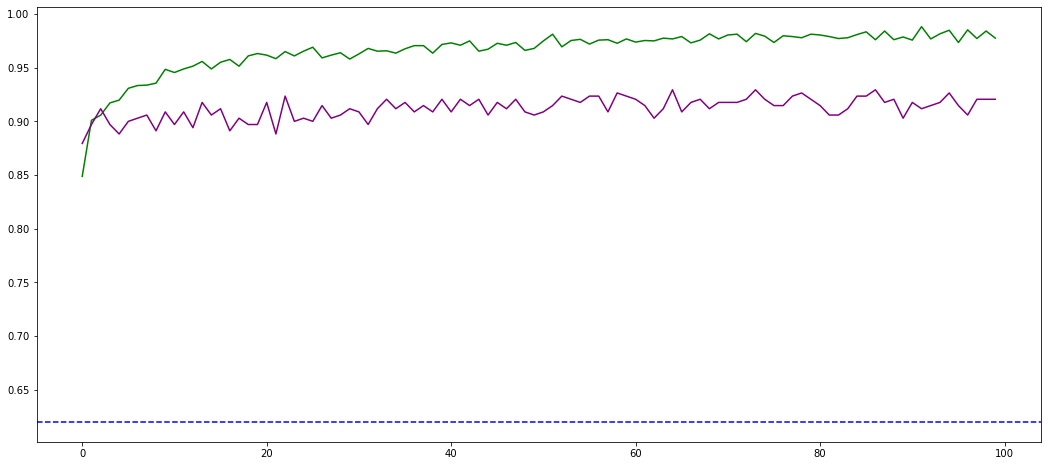

In [8]:
import matplotlib.pyplot as plt

print(history.history.keys())

classify = Transformer.toClassification(activitiesTrain)
constantGuess = (len(classify[classify == 1]))/len(classify)


fig, ax = plt.subplots(figsize=(18,8))

ax.plot(history.history["accuracy"], color="green")
ax.plot(history.history["val_accuracy"], color="purple")
ax.axhline(constantGuess, color="blue", linestyle="dashed")

In [78]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=20000,
    decay_rate=0.9)
optimizer = keras.optimizers.SGD(learning_rate=lr_schedule)


model1 = Sequential()
model1.add(Dense(200, input_dim=np.shape(compoundDataTrain)[1], activation='softmax', kernel_regularizer = keras.regularizers.L2(0.001)))
model1.add(Dense(150, activation='tanh', kernel_regularizer = keras.regularizers.L1(0.001)))
model1.add(Dense(75, activation='relu', kernel_regularizer = keras.regularizers.L1(0.001)))
model1.add(Dense(100, activation='relu', kernel_regularizer = keras.regularizers.L1(0.001)))
model1.add(Dense(100, activation='tanh', kernel_regularizer = keras.regularizers.L1(0.001)))
model1.add(Dense(1, activation='tanh', kernel_regularizer = keras.regularizers.L1(0.001)))

model1.compile(loss='MeanSquaredError', optimizer=optimizer, metrics=['accuracy'])
history = model1.fit(compoundDataTrain, toClassification(activitiesTrain),epochs=400, batch_size=32)

Epoch 1/400
85/85 [==============================] - 1s 2ms/step - loss: 5.5849 - accuracy: 0.0000e+00
Epoch 2/400
85/85 [==============================] - 0s 2ms/step - loss: 5.5255 - accuracy: 0.0000e+00
Epoch 3/400
85/85 [==============================] - 0s 2ms/step - loss: 5.4748 - accuracy: 0.0000e+00
Epoch 4/400
85/85 [==============================] - 0s 2ms/step - loss: 5.4228 - accuracy: 0.0000e+00
Epoch 5/400
85/85 [==============================] - 0s 2ms/step - loss: 5.3735 - accuracy: 0.0000e+00
Epoch 6/400
85/85 [==============================] - 0s 2ms/step - loss: 5.3232 - accuracy: 0.0000e+00
Epoch 7/400
85/85 [==============================] - 0s 2ms/step - loss: 5.2726 - accuracy: 0.0000e+00
Epoch 8/400
85/85 [==============================] - 0s 2ms/step - loss: 5.2224 - accuracy: 0.0000e+00
Epoch 9/400
85/85 [==============================] - 0s 2ms/step - loss: 5.1732 - accuracy: 0.0000e+00
Epoch 10/400
85/85 [==============================] - 0s 2ms/step - loss:

85/85 [==============================] - 0s 2ms/step - loss: 0.5029 - accuracy: 0.6021
Epoch 164/400
85/85 [==============================] - 0s 2ms/step - loss: 0.4964 - accuracy: 0.6018
Epoch 165/400
85/85 [==============================] - 0s 2ms/step - loss: 0.4912 - accuracy: 0.6032
Epoch 166/400
85/85 [==============================] - 0s 2ms/step - loss: 0.4859 - accuracy: 0.6025
Epoch 167/400
85/85 [==============================] - 0s 2ms/step - loss: 0.4792 - accuracy: 0.6025
Epoch 168/400
85/85 [==============================] - 0s 2ms/step - loss: 0.4732 - accuracy: 0.6036
Epoch 169/400
85/85 [==============================] - 0s 2ms/step - loss: 0.4678 - accuracy: 0.6021
Epoch 170/400
85/85 [==============================] - 0s 2ms/step - loss: 0.4623 - accuracy: 0.6032
Epoch 171/400
85/85 [==============================] - 0s 2ms/step - loss: 0.4572 - accuracy: 0.6032
Epoch 172/400
85/85 [==============================] - 0s 2ms/step - loss: 0.4519 - accuracy: 0.6029
Epoc

85/85 [==============================] - 0s 2ms/step - loss: 0.2211 - accuracy: 0.6095
Epoch 326/400
85/85 [==============================] - 0s 2ms/step - loss: 0.2207 - accuracy: 0.6095
Epoch 327/400
85/85 [==============================] - 0s 2ms/step - loss: 0.2202 - accuracy: 0.6099
Epoch 328/400
85/85 [==============================] - 0s 2ms/step - loss: 0.2198 - accuracy: 0.6095
Epoch 329/400
85/85 [==============================] - 0s 2ms/step - loss: 0.2193 - accuracy: 0.6095
Epoch 330/400
85/85 [==============================] - 0s 2ms/step - loss: 0.2188 - accuracy: 0.6099
Epoch 331/400
85/85 [==============================] - 0s 2ms/step - loss: 0.2184 - accuracy: 0.6095
Epoch 332/400
85/85 [==============================] - 0s 2ms/step - loss: 0.2179 - accuracy: 0.6099
Epoch 333/400
85/85 [==============================] - 0s 2ms/step - loss: 0.2175 - accuracy: 0.6095
Epoch 334/400
85/85 [==============================] - 0s 2ms/step - loss: 0.2170 - accuracy: 0.6099
Epoc

In [79]:
classTrain = Transformer.toClassification(activitiesTrain)
classVal = Transformer.toClassification(activitiesValidate)

optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.01,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False
)
#optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)
l1Reg = 0.001

model2 = Sequential()
model2.add(Dense(200, input_dim=np.shape(compoundDataTrain)[1], activation='softmax', kernel_regularizer = keras.regularizers.L2(l1Reg)))
model2.add(Dense(150, activation='tanh', kernel_regularizer = keras.regularizers.L1(0.001)))
model2.add(Dense(75, activation='relu', kernel_regularizer = keras.regularizers.L1(0.001)))
model2.add(Dense(100, activation='relu', kernel_regularizer = keras.regularizers.L1(0.001)))
model2.add(Dense(100, activation='tanh', kernel_regularizer = keras.regularizers.L1(0.001)))
model2.add(Dense(1, activation='tanh', kernel_regularizer = keras.regularizers.L1(0.001)))

model2.compile(loss='MeanSquaredError', optimizer="adam", metrics=['accuracy'])
history = model2.fit(compoundDataTrain, Transformer.toClassification(activitiesTrain), epochs=400, batch_size=4)

Epoch 1/400
680/680 [==============================] - 2s 2ms/step - loss: 1.0603 - accuracy: 0.4026
Epoch 2/400
680/680 [==============================] - 1s 2ms/step - loss: 0.4133 - accuracy: 0.5370
Epoch 3/400
680/680 [==============================] - 1s 2ms/step - loss: 0.3582 - accuracy: 0.5462
Epoch 4/400
680/680 [==============================] - 1s 2ms/step - loss: 0.3242 - accuracy: 0.5565
Epoch 5/400
680/680 [==============================] - 1s 2ms/step - loss: 0.2993 - accuracy: 0.5594
Epoch 6/400
680/680 [==============================] - 1s 2ms/step - loss: 0.2772 - accuracy: 0.5668
Epoch 7/400
680/680 [==============================] - 1s 2ms/step - loss: 0.2527 - accuracy: 0.5709
Epoch 8/400
680/680 [==============================] - 1s 2ms/step - loss: 0.2325 - accuracy: 0.5793
Epoch 9/400
680/680 [==============================] - 1s 2ms/step - loss: 0.2391 - accuracy: 0.5767
Epoch 10/400
680/680 [==============================] - 1s 2ms/step - loss: 0.2306 - accura

680/680 [==============================] - 1s 2ms/step - loss: 0.0888 - accuracy: 0.6110
Epoch 161/400
680/680 [==============================] - 1s 2ms/step - loss: 0.0933 - accuracy: 0.6095
Epoch 162/400
680/680 [==============================] - 1s 2ms/step - loss: 0.0852 - accuracy: 0.6128
Epoch 163/400
680/680 [==============================] - 1s 2ms/step - loss: 0.1125 - accuracy: 0.6047
Epoch 164/400
680/680 [==============================] - 1s 2ms/step - loss: 0.0955 - accuracy: 0.6077
Epoch 165/400
680/680 [==============================] - 1s 2ms/step - loss: 0.0901 - accuracy: 0.6091
Epoch 166/400
680/680 [==============================] - 1s 2ms/step - loss: 0.0961 - accuracy: 0.6091
Epoch 167/400
680/680 [==============================] - 1s 2ms/step - loss: 0.0978 - accuracy: 0.6088
Epoch 168/400
680/680 [==============================] - 1s 2ms/step - loss: 0.0922 - accuracy: 0.6077
Epoch 169/400
680/680 [==============================] - 1s 2ms/step - loss: 0.0921 - a

680/680 [==============================] - 1s 2ms/step - loss: 0.1039 - accuracy: 0.6073
Epoch 319/400
680/680 [==============================] - 1s 2ms/step - loss: 0.0882 - accuracy: 0.6088
Epoch 320/400
680/680 [==============================] - 1s 2ms/step - loss: 0.0953 - accuracy: 0.6084
Epoch 321/400
680/680 [==============================] - 1s 2ms/step - loss: 0.0998 - accuracy: 0.6080
Epoch 322/400
680/680 [==============================] - 2s 2ms/step - loss: 0.0840 - accuracy: 0.6106
Epoch 323/400
680/680 [==============================] - 1s 2ms/step - loss: 0.0917 - accuracy: 0.6102
Epoch 324/400
680/680 [==============================] - 1s 2ms/step - loss: 0.0853 - accuracy: 0.6121
Epoch 325/400
680/680 [==============================] - 1s 2ms/step - loss: 0.1001 - accuracy: 0.6084
Epoch 326/400
680/680 [==============================] - 1s 2ms/step - loss: 0.0939 - accuracy: 0.6113
Epoch 327/400
680/680 [==============================] - 1s 2ms/step - loss: 0.0892 - a

In [80]:
model3 = Sequential()
model3.add(Dense(50, input_dim=np.shape(compoundDataTrain)[1], activation='softmax', kernel_regularizer = keras.regularizers.L2(0.001)))
model3.add(Dense(100, activation='softmax', kernel_regularizer = keras.regularizers.L2(0.001)))
model3.add(Dense(50, activation='relu', kernel_regularizer = keras.regularizers.L2(0.001)))
model3.add(Dense(75, activation='relu', kernel_regularizer = keras.regularizers.L2(0.001)))
model3.add(Dense(100, activation='relu', kernel_regularizer = keras.regularizers.L2(0.001)))
model3.add(Dense(75, activation='relu', kernel_regularizer = keras.regularizers.L2(0.001)))
model3.add(Dense(100, activation='relu', kernel_regularizer = keras.regularizers.L2(0.001)))
model3.add(Dense(1, activation='softmax', kernel_regularizer = keras.regularizers.L2(0.001)))

model3.compile(loss='MeanSquaredError', optimizer='adam', metrics=['accuracy'])

history = model3.fit(compoundDataTrain, toClassification(activitiesTrain), epochs=100, batch_size=32)

Epoch 1/100
85/85 [==============================] - 1s 2ms/step - loss: 1.8043 - accuracy: 0.6198
Epoch 2/100
85/85 [==============================] - 0s 4ms/step - loss: 1.5772 - accuracy: 0.6198
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 1.5297 - accuracy: 0.6198
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 1.5219 - accuracy: 0.6198
Epoch 5/100
85/85 [==============================] - 0s 2ms/step - loss: 1.5209 - accuracy: 0.6198
Epoch 6/100
85/85 [==============================] - 0s 2ms/step - loss: 1.5208 - accuracy: 0.6198
Epoch 7/100
85/85 [==============================] - 0s 2ms/step - loss: 1.5208 - accuracy: 0.6198
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 1.5208 - accuracy: 0.6198
Epoch 9/100
85/85 [==============================] - 0s 2ms/step - loss: 1.5208 - accuracy: 0.6198
Epoch 10/100
85/85 [==============================] - 0s 2ms/step - loss: 1.5208 - accuracy: 0.6198
Epoch 11/

85/85 [==============================] - 0s 2ms/step - loss: 1.5208 - accuracy: 0.6198
Epoch 84/100
85/85 [==============================] - 0s 2ms/step - loss: 1.5208 - accuracy: 0.6198
Epoch 85/100
85/85 [==============================] - 0s 2ms/step - loss: 1.5208 - accuracy: 0.6198
Epoch 86/100
85/85 [==============================] - 0s 2ms/step - loss: 1.5208 - accuracy: 0.6198
Epoch 87/100
85/85 [==============================] - 0s 2ms/step - loss: 1.5208 - accuracy: 0.6198
Epoch 88/100
85/85 [==============================] - 0s 2ms/step - loss: 1.5208 - accuracy: 0.6198
Epoch 89/100
85/85 [==============================] - 0s 3ms/step - loss: 1.5208 - accuracy: 0.6198
Epoch 90/100
85/85 [==============================] - 0s 2ms/step - loss: 1.5208 - accuracy: 0.6198
Epoch 91/100
85/85 [==============================] - 0s 2ms/step - loss: 1.5208 - accuracy: 0.6198
Epoch 92/100
85/85 [==============================] - 0s 2ms/step - loss: 1.5208 - accuracy: 0.6198
Epoch 93/100


In [83]:
print("Aggregation: ", np.mean(toClassification(activitiesValidate) == takeVote([model1,model2,model3], compoundDataValidate, toClassification(activitiesValidate))))
print(np.mean(toClassification(activitiesValidate) == np.sign(model1.predict(compoundDataValidate))))
print(np.mean(toClassification(activitiesValidate) == np.sign(model2.predict(compoundDataValidate))))
print(np.mean(toClassification(activitiesValidate) == np.sign(model3.predict(compoundDataValidate))))

11/11 [==============================] - 0s 1ms/step
Aggregation:  0.5276124567474049
11/11 [==============================] - 0s 2ms/step
0.5216955017301038
11/11 [==============================] - 0s 2ms/step
0.5223529411764706
11/11 [==============================] - 0s 2ms/step
0.611764705882353


# Using the PCA components

In [85]:
compoundsTrain, smilesTrain, labelsTrain, compoundDataTrain, activitiesTrain = Loader.getTrain(defaultValue=0)
compoundsTest, smilesTest, labelsTest, compoundDataTest, activitiesTest = Loader.getTest(defaultValue=0)
compoundsValidate, smilesValidate, labelsValidate, compoundDataValidate, activitiesValidate = Loader.getValidate(defaultValue=0)


labelsPCA, trainPCA, testPCA, valPCA = Transformer.applyPCA(labelsTrain,  compoundDataTrain, 
                                                            compoundDataTest, compoundDataValidate,
                                                            endDims=[1,1,9,4,6,7,3,16])

labelsMeanPCA, trainMeanPCA = Transformer.useAverageFD(labelsPCA, trainPCA)
_, testMeanPCA = Transformer.useAverageFD(labelsPCA, testPCA)
_, valMeanPCA = Transformer.useAverageFD(labelsPCA, valPCA)

labelsMaxPCA, trainMaxPCA = Transformer.useMaxFD(labelsPCA, trainPCA)
_, testMaxPCA = Transformer.useMaxFD(labelsPCA, testPCA)
_, valMaxPCA = Transformer.useMaxFD(labelsPCA, valPCA)

#after transformations are done assign data
dataLabels = labelsMaxPCA
trainData = trainMaxPCA
testData = testMaxPCA
valData = valMaxPCA

trainData, testData, valData = Transformer.normalizeData(trainData, testData, valData, newMean=0, newStd=1)

print(np.shape(trainData))
for i in range(len(dataLabels)):
    print(i, "\b:\t", dataLabels[i], "\t", trainData[0:3,i])

bcut2d retention: [0.99364773]
	total: 99.36477273412339%
chi retention: [0.9541968]
	total: 95.41967968597889%
paoe retention: [0.31495127 0.19509321 0.1390042  0.08838179 0.07155396 0.04590061
 0.03243    0.02673268 0.02402293]
	total: 93.80706737004672%
smr retention: [0.50634726 0.24568468 0.08792319 0.07435827]
	total: 91.43133907840063%
slogp retention: [0.44620276 0.22134465 0.15753302 0.04213752 0.03159298 0.02850562]
	total: 92.73165471968964%
estate_vsa retention: [0.29224011 0.18964809 0.14361318 0.10642656 0.07394495 0.06391846
 0.05513575]
	total: 92.49271047439834%
vsa_estate retention: [0.49255304 0.32866098 0.09719245]
	total: 91.84064669216797%
fr retention: [0.32153498 0.12578177 0.09944384 0.0570485  0.05494644 0.04503917
 0.03646285 0.02896244 0.02597271 0.02289905 0.01957315 0.01726897
 0.01514305 0.01174696 0.01137838 0.00991623]
	total: 90.31185029428742%
(2717, 95)
0 :	 docking_score_max 	 [1.8401924  1.40725282 0.10843408]
1 :	 fusion_score_max 	 [0.04179651 

# Training on Fr data

In [86]:
dataX = np.array(trainData)[:,79:len(trainData)]
model1 = Sequential()
model1.add(Dense(200, input_dim=np.shape(dataX)[1], activation='relu', kernel_regularizer = keras.regularizers.L2(0.001)))
model1.add(Dense(100, activation='relu', kernel_regularizer = keras.regularizers.L1(0.001)))
model1.add(Dense(100, activation='tanh', kernel_regularizer = keras.regularizers.L1(0.001)))
model1.add(Dense(1, activation='tanh', kernel_regularizer = keras.regularizers.L1(0.001)))

model1.compile(loss='MeanSquaredError', optimizer="adam", metrics=['accuracy'])
history = model1.fit(dataX, toClassification(activitiesTrain),epochs=100, batch_size=32)

Epoch 1/100
85/85 [==============================] - 1s 2ms/step - loss: 2.5404 - accuracy: 0.3890
Epoch 2/100
85/85 [==============================] - 0s 2ms/step - loss: 1.7911 - accuracy: 0.4921
Epoch 3/100
85/85 [==============================] - 0s 2ms/step - loss: 1.3597 - accuracy: 0.5127
Epoch 4/100
85/85 [==============================] - 0s 2ms/step - loss: 1.1017 - accuracy: 0.5171
Epoch 5/100
85/85 [==============================] - 0s 2ms/step - loss: 0.9131 - accuracy: 0.5234
Epoch 6/100
85/85 [==============================] - 0s 2ms/step - loss: 0.7799 - accuracy: 0.5230
Epoch 7/100
85/85 [==============================] - 0s 2ms/step - loss: 0.6949 - accuracy: 0.5271
Epoch 8/100
85/85 [==============================] - 0s 2ms/step - loss: 0.6241 - accuracy: 0.5278
Epoch 9/100
85/85 [==============================] - 0s 2ms/step - loss: 0.5795 - accuracy: 0.5274
Epoch 10/100
85/85 [==============================] - 0s 2ms/step - loss: 0.5334 - accuracy: 0.5348
Epoch 11/

85/85 [==============================] - 0s 2ms/step - loss: 0.1832 - accuracy: 0.6018
Epoch 84/100
85/85 [==============================] - 0s 2ms/step - loss: 0.1838 - accuracy: 0.6007
Epoch 85/100
85/85 [==============================] - 0s 2ms/step - loss: 0.1909 - accuracy: 0.5996
Epoch 86/100
85/85 [==============================] - 0s 2ms/step - loss: 0.1869 - accuracy: 0.5992
Epoch 87/100
85/85 [==============================] - 0s 2ms/step - loss: 0.1880 - accuracy: 0.5999
Epoch 88/100
85/85 [==============================] - 0s 2ms/step - loss: 0.1874 - accuracy: 0.6007
Epoch 89/100
85/85 [==============================] - 0s 2ms/step - loss: 0.1937 - accuracy: 0.5944
Epoch 90/100
85/85 [==============================] - 0s 2ms/step - loss: 0.1860 - accuracy: 0.5996
Epoch 91/100
85/85 [==============================] - 0s 2ms/step - loss: 0.1875 - accuracy: 0.6007
Epoch 92/100
85/85 [==============================] - 0s 2ms/step - loss: 0.1857 - accuracy: 0.6021
Epoch 93/100


# Training on Structure Data

In [87]:
dataX = np.array(trainData)[:,59:79]

model2 = Sequential()
model2.add(Dense(200, input_dim=np.shape(dataX)[1], activation='relu', kernel_regularizer = keras.regularizers.L2(0.001)))
model2.add(Dense(100, activation='relu', kernel_regularizer = keras.regularizers.L1(0.001)))
model2.add(Dense(100, activation='tanh', kernel_regularizer = keras.regularizers.L1(0.001)))
model2.add(Dense(1, activation='tanh', kernel_regularizer = keras.regularizers.L1(0.001)))

model2.compile(loss='MeanSquaredError', optimizer="adam", metrics=['accuracy'])
history = model2.fit(dataX, toClassification(activitiesTrain),epochs=100, batch_size=32)

Epoch 1/100
85/85 [==============================] - 1s 2ms/step - loss: 2.6477 - accuracy: 0.3198
Epoch 2/100
85/85 [==============================] - 0s 2ms/step - loss: 1.9294 - accuracy: 0.4188
Epoch 3/100
85/85 [==============================] - 0s 2ms/step - loss: 1.5379 - accuracy: 0.4284
Epoch 4/100
85/85 [==============================] - 0s 2ms/step - loss: 1.2741 - accuracy: 0.4457
Epoch 5/100
85/85 [==============================] - 0s 2ms/step - loss: 1.1011 - accuracy: 0.4479
Epoch 6/100
85/85 [==============================] - 0s 2ms/step - loss: 0.9612 - accuracy: 0.4575
Epoch 7/100
85/85 [==============================] - 0s 2ms/step - loss: 0.8719 - accuracy: 0.4626
Epoch 8/100
85/85 [==============================] - 0s 2ms/step - loss: 0.7876 - accuracy: 0.4682
Epoch 9/100
85/85 [==============================] - 0s 2ms/step - loss: 0.7347 - accuracy: 0.4663
Epoch 10/100
85/85 [==============================] - 0s 2ms/step - loss: 0.6951 - accuracy: 0.4744
Epoch 11/

85/85 [==============================] - 0s 2ms/step - loss: 0.2969 - accuracy: 0.5668
Epoch 84/100
85/85 [==============================] - 0s 2ms/step - loss: 0.2821 - accuracy: 0.5705
Epoch 85/100
85/85 [==============================] - 0s 2ms/step - loss: 0.2734 - accuracy: 0.5686
Epoch 86/100
85/85 [==============================] - 0s 2ms/step - loss: 0.2782 - accuracy: 0.5709
Epoch 87/100
85/85 [==============================] - 0s 2ms/step - loss: 0.2745 - accuracy: 0.5720
Epoch 88/100
85/85 [==============================] - 0s 2ms/step - loss: 0.3017 - accuracy: 0.5690
Epoch 89/100
85/85 [==============================] - 0s 2ms/step - loss: 0.2840 - accuracy: 0.5734
Epoch 90/100
85/85 [==============================] - 0s 2ms/step - loss: 0.2931 - accuracy: 0.5675
Epoch 91/100
85/85 [==============================] - 0s 2ms/step - loss: 0.2805 - accuracy: 0.5675
Epoch 92/100
85/85 [==============================] - 0s 2ms/step - loss: 0.2763 - accuracy: 0.5675
Epoch 93/100


# Training on TPSA, VSA ESTATE and ESTATE VSA

In [1]:
dataX = np.array(trainData)[:,48:59]

model3 = Sequential()
model3.add(Dense(200, input_dim=np.shape(dataX)[1], activation='relu', kernel_regularizer = keras.regularizers.L2(0.001)))
model3.add(Dense(100, activation='relu', kernel_regularizer = keras.regularizers.L1(0.001)))
model3.add(Dense(100, activation='tanh', kernel_regularizer = keras.regularizers.L1(0.001)))
model3.add(Dense(1, activation='tanh', kernel_regularizer = keras.regularizers.L1(0.001)))

model3.compile(loss='MeanSquaredError', optimizer="adam", metrics=['accuracy'])
history = model3.fit(dataX, toClassification(activitiesTrain),epochs=200, batch_size=32)

NameError: name 'np' is not defined

# Training on Slogp, SMR, and PAOE

In [89]:
dataX = np.array(trainData)[:,29:48]

model4 = Sequential()
model4.add(Dense(200, input_dim=np.shape(dataX)[1], activation='relu', kernel_regularizer = keras.regularizers.L2(0.001)))
model4.add(Dense(100, activation='relu', kernel_regularizer = keras.regularizers.L1(0.001)))
model4.add(Dense(100, activation='tanh', kernel_regularizer = keras.regularizers.L1(0.001)))
model4.add(Dense(1, activation='tanh', kernel_regularizer = keras.regularizers.L1(0.001)))

model4.compile(loss='MeanSquaredError', optimizer="adam", metrics=['accuracy'])
history = model4.fit(dataX, toClassification(activitiesTrain),epochs=100, batch_size=32)

Epoch 1/100
85/85 [==============================] - 1s 2ms/step - loss: 2.5360 - accuracy: 0.3993
Epoch 2/100
85/85 [==============================] - 0s 2ms/step - loss: 1.8129 - accuracy: 0.4799
Epoch 3/100
85/85 [==============================] - 0s 2ms/step - loss: 1.3916 - accuracy: 0.4906
Epoch 4/100
85/85 [==============================] - 0s 2ms/step - loss: 1.1047 - accuracy: 0.5013
Epoch 5/100
85/85 [==============================] - 0s 2ms/step - loss: 0.9185 - accuracy: 0.5050
Epoch 6/100
85/85 [==============================] - 0s 2ms/step - loss: 0.7782 - accuracy: 0.5094
Epoch 7/100
85/85 [==============================] - 0s 2ms/step - loss: 0.6980 - accuracy: 0.5116
Epoch 8/100
85/85 [==============================] - 0s 2ms/step - loss: 0.6166 - accuracy: 0.5219
Epoch 9/100
85/85 [==============================] - 0s 2ms/step - loss: 0.5789 - accuracy: 0.5153
Epoch 10/100
85/85 [==============================] - 0s 2ms/step - loss: 0.5293 - accuracy: 0.5282
Epoch 11/

85/85 [==============================] - 0s 2ms/step - loss: 0.1814 - accuracy: 0.5977
Epoch 84/100
85/85 [==============================] - 0s 2ms/step - loss: 0.1715 - accuracy: 0.6014
Epoch 85/100
85/85 [==============================] - 0s 2ms/step - loss: 0.1662 - accuracy: 0.6040
Epoch 86/100
85/85 [==============================] - 0s 2ms/step - loss: 0.1670 - accuracy: 0.6025
Epoch 87/100
85/85 [==============================] - 0s 2ms/step - loss: 0.1637 - accuracy: 0.6062
Epoch 88/100
85/85 [==============================] - 0s 2ms/step - loss: 0.1587 - accuracy: 0.6066
Epoch 89/100
85/85 [==============================] - 0s 2ms/step - loss: 0.1592 - accuracy: 0.6069
Epoch 90/100
85/85 [==============================] - 0s 2ms/step - loss: 0.1484 - accuracy: 0.6113
Epoch 91/100
85/85 [==============================] - 0s 2ms/step - loss: 0.1460 - accuracy: 0.6110
Epoch 92/100
85/85 [==============================] - 0s 2ms/step - loss: 0.1407 - accuracy: 0.6132
Epoch 93/100


# Training on the remaining Compound Data

In [93]:
dataX = np.array(trainData)[:,:29]

model5 = Sequential()
model5.add(Dense(200, input_dim=np.shape(dataX)[1], activation='relu', kernel_regularizer = keras.regularizers.L2(0.001)))
model5.add(Dense(100, activation='relu', kernel_regularizer = keras.regularizers.L1(0.001)))
model5.add(Dense(100, activation='tanh', kernel_regularizer = keras.regularizers.L1(0.001)))
model5.add(Dense(1, activation='tanh', kernel_regularizer = keras.regularizers.L1(0.001)))

model5.compile(loss='MeanSquaredError', optimizer="adam", metrics=['accuracy'])
history = model5.fit(dataX, toClassification(activitiesTrain),epochs=100, batch_size=32)

Epoch 1/100
85/85 [==============================] - 1s 2ms/step - loss: 2.6314 - accuracy: 0.3909
Epoch 2/100
85/85 [==============================] - 0s 2ms/step - loss: 1.9729 - accuracy: 0.4479
Epoch 3/100
85/85 [==============================] - 0s 2ms/step - loss: 1.5700 - accuracy: 0.4619
Epoch 4/100
85/85 [==============================] - 0s 2ms/step - loss: 1.2946 - accuracy: 0.4737
Epoch 5/100
85/85 [==============================] - 0s 2ms/step - loss: 1.1142 - accuracy: 0.4799
Epoch 6/100
85/85 [==============================] - 0s 2ms/step - loss: 0.9671 - accuracy: 0.4825
Epoch 7/100
85/85 [==============================] - 0s 2ms/step - loss: 0.8723 - accuracy: 0.4851
Epoch 8/100
85/85 [==============================] - 0s 2ms/step - loss: 0.7988 - accuracy: 0.4917
Epoch 9/100
85/85 [==============================] - 0s 2ms/step - loss: 0.7280 - accuracy: 0.4943
Epoch 10/100
85/85 [==============================] - 0s 2ms/step - loss: 0.6700 - accuracy: 0.4987
Epoch 11/

85/85 [==============================] - 0s 1ms/step - loss: 0.2470 - accuracy: 0.5845
Epoch 84/100
85/85 [==============================] - 0s 2ms/step - loss: 0.2314 - accuracy: 0.5863
Epoch 85/100
85/85 [==============================] - 0s 1ms/step - loss: 0.2187 - accuracy: 0.5951
Epoch 86/100
85/85 [==============================] - 0s 1ms/step - loss: 0.2281 - accuracy: 0.5918
Epoch 87/100
85/85 [==============================] - 0s 1ms/step - loss: 0.2326 - accuracy: 0.5863
Epoch 88/100
85/85 [==============================] - 0s 1ms/step - loss: 0.2379 - accuracy: 0.5867
Epoch 89/100
85/85 [==============================] - 0s 1ms/step - loss: 0.2575 - accuracy: 0.5819
Epoch 90/100
85/85 [==============================] - 0s 1ms/step - loss: 0.2359 - accuracy: 0.5881
Epoch 91/100
85/85 [==============================] - 0s 1ms/step - loss: 0.2452 - accuracy: 0.5830
Epoch 92/100
85/85 [==============================] - 0s 1ms/step - loss: 0.2271 - accuracy: 0.5911
Epoch 93/100


In [91]:
dataInds = [[79,len(trainData)],[59,79],[48,59],[29,48],[0,29]]
yAgg = takeVote([model1,model2,model3,model4,model5], valData, toClassification(activitiesValidate), False, dataInds)
print(yAgg)
print(np.mean(toClassification(activitiesValidate) == yAgg))

11/11 [==============================] - 0s 978us/step
[[-1. -1. -1. ... -1. -1. -1.]
 [ 1.  1.  1. ...  1.  1.  1.]
 [ 1.  1.  1. ...  1.  1.  1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [ 1.  1.  1. ...  1.  1.  1.]]
0.5216955017301038


In [92]:
valData = np.array(valData)
print(np.mean(toClassification(activitiesValidate) == np.sign(model1.predict(valData[:,79:]))))
print(np.mean(toClassification(activitiesValidate) == np.sign(model2.predict(valData[:,59:79]))))
print(np.mean(toClassification(activitiesValidate) == np.sign(model3.predict(valData[:,48:59]))))
print(np.mean(toClassification(activitiesValidate) == np.sign(model4.predict(valData[:,29:48]))))
print(np.mean(toClassification(activitiesValidate) == np.sign(model5.predict(valData[:,0:29]))))

11/11 [==============================] - 0s 1ms/step
0.5256401384083045
11/11 [==============================] - 0s 1ms/step
0.5256401384083045
11/11 [==============================] - 0s 1ms/step
0.5322145328719723
11/11 [==============================] - 0s 1ms/step
0.5282698961937716
11/11 [==============================] - 0s 1ms/step
0.5249826989619377
